Данная часть работы выполняется на основе визуального анализа данных, его можно найти в репозитории.

Цель работы - разработать модель, позволяющую относить клиента телеком-оператора к одному из классов (отток / не отток) с целью проведения кампании по удержанию клиента. Метрика качества - ROC-AUC и связанный с ней Индекс Джини, что позволяет оценить качество алгоритма в денежном выражении. При разработке алгоритма учитывалась стратегия удержания клиентов, заключающаяся в рассылке смс-писем на личный номер абонента с предложением о скидке на услуги сотовой связи.

In [115]:
#Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from category_encoders import OrdinalEncoder, LeaveOneOutEncoder, CatBoostEncoder, TargetEncoder, WOEEncoder, JamesSteinEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.model_selection import train_test_split, cross_val_score,  StratifiedKFold, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import learning_curve
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
import joblib
import scipy as sc
from scipy import stats
from numpy.random import RandomState
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic
import warnings
import itertools
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#загрузим предобработанные данные
X = pd.read_csv('data/data_cleaned.csv')
X.head(5)

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var189_usnull,Var7_usnull,Var73_usnull,Var126_usnull,Var113_usnull,Var144_usnull,Var13_usnull,Var65_usnull,Var72_usnull,Var81_usnull
0,3052.0,NaN,NaN,480.0,600.0,20.0,480.0,200.00,0.0,82752.0,...,1,1,0,0,0,0,1,1,1,0
1,1813.0,7.0,636.0,212.0,265.0,2.0,128.0,166.56,0.0,2706120.0,...,0,0,0,0,0,0,0,0,0,0
2,1953.0,7.0,448.0,176.0,220.0,0.0,72.0,311.76,0.0,4698780.0,...,1,0,0,0,0,0,0,0,0,0
3,1533.0,7.0,4.0,332.0,415.0,0.0,144.0,220.08,5.0,864384.0,...,1,0,0,1,0,0,0,0,1,0
4,686.0,7.0,0.0,160.0,200.0,2.0,48.0,278.00,0.0,4364880.0,...,1,0,0,0,0,0,0,0,0,0


In [3]:
y = pd.read_csv('data/orange_small_churn_labels.train', header=None)
y = y.replace({-1:0})

In [4]:
#поделим на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, test_size=0.2, random_state=17)

### Определение типа признаков

Пока будет пользоваться catboost, он не требует предобработки данных и достаточно хорошо и быстро работает. Оценим как присвоение иного типа признакам (отличного типа от того, что предоставил организатор) влияет на качество при использовании Supervised кодирования

In [5]:
#автоматически определим категориальные и числовые признаки
num_cols = X_train.dtypes[X_train.dtypes != 'object'].index
cat_cols = X_train.dtypes[X_train.dtypes == 'object'].index

In [6]:
#базовые значения
#заменим пропуски в категориальных на редкие категории
X_train_cat = X_train
X_train_cat[cat_cols] = X_train_cat[cat_cols].fillna('-999')

clf = CatBoostClassifier(random_seed=17, eval_metric='AUC', verbose=False,
                        early_stopping_rounds=50, nan_mode='Max', loss_function='Logloss')

In [35]:
cv_results_base = cv(Pool(X_train_cat, y_train, cat_features=cat_cols), clf.get_params(), stratified=True,
                     early_stopping_rounds=50, seed=17, plot=False, verbose=False, shuffle=True)

Stopped by overfitting detector  (50 iterations wait)


In [36]:
cv_results_base['test-AUC-mean'].max()

0.7476679329703843

In [7]:
#добавим новые категориальные признаки
new_cat_cols = ['Var173', 'Var143', 'Var7', 'Var181', 'Var44', 'Var72', 'Var144', 'Var35', 'Var78', 'Var65', 'Var132']
cat_cols_new = cat_cols.tolist()
cat_cols_new = cat_cols_new + new_cat_cols
num_cols_new = [x for x in X.columns if x not in cat_cols_new]


In [8]:
#попробуем добавить признаки, визуально похожие на категориальные и снова проверим качество

X_train_cat[cat_cols_new] = X_train_cat[cat_cols_new].fillna('-999')
X_train_cat[cat_cols_new] = X_train_cat[cat_cols_new].astype(str)

In [41]:
cv_results_new = cv(Pool(X_train_cat, y_train, cat_features=cat_cols_new), clf.get_params(), stratified=True,
                     early_stopping_rounds=50, seed=17, plot=False, verbose=False, shuffle=True)

Stopped by overfitting detector  (50 iterations wait)


In [42]:
cv_results_new['test-AUC-mean'].max()

0.7482478367466948

In [9]:
cat_cols = cat_cols_new
num_cols = num_cols_new

В целом результат стал немного лучше, однако полностью ему доверять нельзя. На данном этапе оставим эти признаки и продолжим работу с выборкой

### Обработка редких категорий

Как было установлено, в категориальных признаках много таких, в которых имются редкие категории, то есть внутри признака какая-то категория встречается не более 1-5 раз. Попробуем их объединять и посмотрим на качество по валидации

In [44]:
#Определим класс для обработки редких категорий

class RareEncoder(BaseEstimator, TransformerMixin):
    '''
    Наследуем базовые классы sklearn, связывающие fit_transform
    параметр класса threshold - минимальная частота,
    при которой не происходит укрупленение категорий
    
    '''
    
    def __init__(self, threshold=0.01):
        self.d = defaultdict(list)
        self.threshold = threshold
     #учим кодировщик   
    def fit(self, X, y=None):
        n_obs = len(X)
        for col in X.columns:
            #вычисляем частоты
            rel_freq = X[col].value_counts(dropna=False) / n_obs
            #записываем в словарь
            self.d[col] = rel_freq[rel_freq >= self.threshold].index.tolist()
            
        return self
        #тут отрабатывает кодировщик
    def transform(self, X):
        X = X.copy()#экземпляр датафрейма, чтобы не валились предупреждения
            #если переменной категории нет в словаре, значит их частоты ниже порога, тогда отнесем их к классу 'other'
        for col in X.columns:
            X[col] = np.where(X[col].isin(self.d[col]), X[col], 'other')
        return X

In [45]:
#переберем несколько порогов и посмотрим на результат
for thresh in [0.01, 0.02, 0.03, 0.05, 0.1]:
    
    enlarged_train_x = X_train_cat.copy()
    r_encoder = RareEncoder(threshold=thresh)
    for col in cat_cols:
        r_encoder.fit(enlarged_train_x[[col]])
        enlarged_train_x[col] = r_encoder.transform(enlarged_train_x[[col]])
    #результат после слияния редких категорий
    cv_results = cv(Pool(enlarged_train_x, y_train, cat_features=cat_cols), clf.get_params(), stratified=True,
                early_stopping_rounds=50, seed=17, plot=False, verbose=False, shuffle=True)
    print(cv_results['test-AUC-mean'].max())

Stopped by overfitting detector  (50 iterations wait)
0.742413436334482
Stopped by overfitting detector  (50 iterations wait)
0.7423243528790687
Stopped by overfitting detector  (50 iterations wait)
0.7420622735196046
Stopped by overfitting detector  (50 iterations wait)
0.74077871152135
Stopped by overfitting detector  (50 iterations wait)
0.739950479522988


Укрупнение категорий понижает качество модели. Далее мы им пользоваться не будем, в итоге датасет будет использоваться для модели в его исходном виде.


## Отбор признаков

In [47]:
#попробуем 2 стратегии отбора признаков
#1 - удалим те, которые дают нулевой вклад в модель
#2 - вручную перебем колонки и удалим те, которые понижают качество модели
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_train_cat, y_train,
                                                                    stratify=y_train, shuffle=True, test_size=0.2, random_state=17)



In [48]:
#модель катбуста
def model_catboost(X_train_new, y_train, X_valid, y_valid):
    model = CatBoostClassifier(
    random_seed=17,
    #расчет на ГПУ примерно в 2,5р быстрее (GTX 1050 Ti vs i5 7300HQ)
    task_type='GPU',
    #ранняя остановка
    early_stopping_rounds=200,
    #считаем целевую метрику
    eval_metric='AUC')
    #обучение
    model.fit(
    X_train_new, train_y,
    cat_features=cat_cols,
    eval_set=(X_valid, y_valid),
    verbose=False)
    
    return model

In [49]:
#обучаем модель
model = model_catboost(X_train_new, y_train_new, X_test_new,  y_test_new)

In [58]:
#список признаков по их важности
feature_scores = pd.DataFrame(list(zip(X_train_new.dtypes.index, model.get_feature_importance(Pool(X_train_new,
                                                                                                 label=train_y,
                                                                                                 cat_features=cat_cols)))),
                             columns=['Feature_name', 'Score'])
#соритовка
feature_scores = feature_scores.sort_values(by='Score', ascending=False, inplace=False, na_position='last')

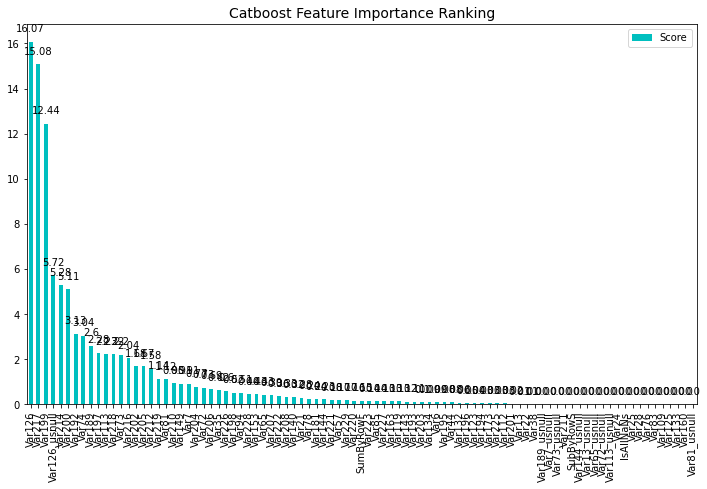

In [59]:
#отрисовка важности признаков
plt.rcParams["figure.figsize"] = (12,7)
ax = feature_scores.plot('Feature_name', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_scores['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [60]:
#слабые признаки имеются, их выкинем если их важность нулевая
features_to_delete = feature_scores[feature_scores['Score'] == 0.0]['Feature_name']
features_to_delete = [x for x in features_to_delete]
cat_cols = [x for x in cat_cols]
num_cols = [x for x in num_cols]

In [61]:
#выкинем фичи с нулевой важность по результатам отбора
train_x_drop = X_train_cat.drop(features_to_delete, axis=1)
#выберем новое пространство категориальных признаков
cat_cols_selected = train_x_drop.dtypes[train_x_drop.dtypes=='object'].index
num_cols_selected = [x for x in train_x_drop.columns if x not in cat_cols_selected]

In [62]:
cv_results_corrected = cv(Pool(train_x_drop, y_train, cat_features=cat_cols_selected),
                          clf.get_params(), stratified=True, early_stopping_rounds=50, seed=17, plot=False, verbose=False)

Stopped by overfitting detector  (50 iterations wait)


In [63]:
print('Mean result after feature selection = ', cv_results_corrected['test-AUC-mean'].max())
print('Common result = ', cv_results_new['test-AUC-mean'].max())

Mean result after feature selection =  0.7481691083883867
Common result =  0.7482478367466948


Хоть модель и считает признаки бесполезными, судя по всему, в некоторых фолдах она использует данные признаки пусть и где-то в самом конце. Признаки, показывающие наибольшую важность, так же были отмечены как сильно коррелирующие с целевой переменной. Два признака, созданных на этапе EDA, кроме того, помогают улучшить качество модели. 

In [64]:
#контейнер для хранения результатов
scores_num = []
#все числовые признаки, удаляем по очереди одну фичу и смотрим результат
#после этого фича возвращается и удаляется следующая
for col in num_cols:
    #копируем данные
    X_train_copy = X_train_cat.copy()
    #выбрасываем переменную для определения ее важности
    X_train_copy = X_train_copy.drop(col, axis=1)
    #выбрасываем переменную для определения ее важности
    #обучаем модель на n-1 переменной
    cv_results = cv(Pool(X_train_copy, y_train, cat_features=cat_cols), clf.get_params(), stratified=True, early_stopping_rounds=50,
               seed=17, plot=False, verbose=False, shuffle=True)
    #фиксируем результат модели без данной переменной
    scores_num.append((col, cv_results['test-AUC-mean'].max()))



Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detec

In [65]:
#то же самое для всех категориальных признаков
scores_cat = []
for col in cat_cols:
    #копируем данные
    X_train_copy = X_train_cat.copy()
    #выбрасываем переменную для определения ее важности
    X_train_copy = X_train_copy.drop(col, axis=1) 
    #переопределяем имена категориальных признаков с учетом того, что один был выброшен
    cat_cols_copy = X_train_copy.dtypes[X_train_copy.dtypes=='object'].index
    num_cols_copy = [x for x in X_train_copy.columns if x not in cat_cols]
    #обучаем модель на n-1 переменной
    cv_results = cv(Pool(X_train_copy, y_train, cat_features=cat_cols_copy), clf.get_params(), stratified=True, early_stopping_rounds=50,
               seed=17, plot=False, verbose=False, shuffle=True)
    #фиксируем результат модели без данной переменной
    scores_cat.append((col, cv_results['test-AUC-mean'].max()))

Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detec

In [68]:
scores = scores_num + scores_cat

In [69]:
#соберем все это в удобный табличный вид
scores_table = pd.DataFrame(scores, columns=['Var', 'Score'])
base = cv_results_base['test-AUC-mean'].max()
scores_table['diff'] = scores_table['Score'] - base
scores_table.sort_values(by='diff', ascending=False)

,Var,Score,diff
5,Var25,0.750305,0.002637
50,Var198,0.749894,0.002226
31,IsAllNaNs,0.749798,0.002130
38,Var113_usnull,0.749726,0.002058
73,Var225,0.749531,0.001863
...,...,...,...
57,Var205,0.745920,-0.001748
51,Var199,0.745043,-0.002625
30,Var189,0.744831,-0.002837
18,Var113,0.744505,-0.003163


Видно, что по важности признак Var126 Так же остается сильно вносящим вклад в модель. Результаты от выброса некоторых признаков отличаются только в 4 знаке, улучшения существенного не происходит.


### Выбор метода кодирования категориальных признаков

Catboost из коробки использует свой метод кодирования, несмещенный catboost-encoder, разработанный специально для данного вида градиентного бустинга) XGBoost/LightGBM не имеет встроенных инструметров и признаки надо предобрабатывать. Существуеют два вида кодировщиков: Supervised/unsupervised. Если для линейных методов первый вид не будет улучшать качество, то для деревьев он будет более предпочтителен. Если кодирование строится на основе зависимой переменной разбиение дерева будет более качественным и для достижения лучшего результата будут нужны менее глубокие деревья. Переберем некоторые виды supervisid и сравним с ordinal и выберем кодировщик для использования в финальной модели.

In [70]:
#список кодировщиков
encoder_list = [OrdinalEncoder,
                LeaveOneOutEncoder,
                CatBoostEncoder,
                TargetEncoder,
                WOEEncoder,
                JamesSteinEncoder]

In [71]:
#определим функцию для сравнения кодировщиков, в качестве алгоритма будет использовать LightGBM из коробки
def encode(encoder):

    #преобразование для числовых признаков
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean'))])
    #кодировка категориальных
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='-999')),
        ('woe', encoder())])
    #трансформер
    preprocessor = ColumnTransformer(
    transformers=[
            ('num', numeric_transformer, num_cols),
            ('cat', categorical_transformer, cat_cols)])
    #собираем конвеер из двух этапов
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', lgb.LGBMClassifier(random_state=17, metrics='auc', n_jobs=2))])
    #будем смотреть на кросс-валидацию по 5 фолдам
    cv_results = cross_val_score(pipe, X_train, y_train, cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True), n_jobs=2,
                                    scoring='roc_auc')


    return print(encoder, cv_results.mean(), cv_results)

In [72]:
for encoder in encoder_list:
    encode(encoder)

<class 'category_encoders.ordinal.OrdinalEncoder'> 0.7217428722303026 [0.71998536 0.70692462 0.74098703 0.7272805  0.71353686]
<class 'category_encoders.leave_one_out.LeaveOneOutEncoder'> 0.5803692398809337 [0.5648544  0.5666648  0.60280464 0.58638731 0.58113505]
<class 'category_encoders.cat_boost.CatBoostEncoder'> 0.65750103408515 [0.63544941 0.6787569  0.61630726 0.67229905 0.68469255]
<class 'category_encoders.target_encoder.TargetEncoder'> 0.7287898143494298 [0.72594495 0.72087478 0.73667576 0.73951495 0.72093863]
<class 'category_encoders.woe.WOEEncoder'> 0.7302613548271361 [0.72595914 0.72462679 0.73996249 0.74155018 0.71920818]
<class 'category_encoders.james_stein.JamesSteinEncoder'> 0.7268729075079479 [0.72631448 0.71374277 0.73593742 0.73941406 0.71895581]


Многие supervised кодировщики улучшают прогноз модели. Будем далее пользоваться Target

### Подбор гиперпараметров LightGBM/XGBoost

Загрузим данные, поскольку при настройке catboost они немного засорились заменами пропусков

In [10]:
#создадим цепочку предобработки данных
#категориальные признаки
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='constant')),
                     ('encoder', TargetEncoder())])
#целочисленные признаки
num_pipe = Pipeline([('imputer', SimpleImputer(strategy='mean'))])
#собираем в трансформер
transformer = ColumnTransformer(transformers=[('num', num_pipe, num_cols),
                                              ('cat', cat_pipe, cat_cols)])

lgb_pipeline = Pipeline([('tr', transformer),
                         ('lgb', lgb.LGBMClassifier(random_state=17))])
xgb_pipeline = Pipeline([('tr', transformer),
                         ('classifier', xgb.XGBClassifier(random_state=17))])

In [11]:
import optuna
from optuna.samplers import RandomSampler
from optuna.integration import OptunaSearchCV
from optuna.distributions import LogUniformDistribution, CategoricalDistribution, UniformDistribution, IntUniformDistribution
from optuna.visualization import plot_slice, plot_optimization_history, plot_contour


In [ ]:
#функция потерь для optuna
def objective(trial):
    #выбираем из двух классификаторов
    classifier_name = trial.suggest_categorical('classifier', ['lightgbm', 'xgboost'])
    #параметры XGBoost
    if classifier_name == 'xgboost':
        params = {
            'classifier__max_depth' : int(trial.suggest_loguniform('classifier__max_depth', 2, 32)),
            'classifier__n_estimators' : int(trial.suggest_uniform('classifier__n_estimators', 100, 600)),
            'classifier__learning_rate' : trial.suggest_loguniform('xclassifier__learning_rate',  1e-3, 1.0),
            'classifier__min_child_weight' : trial.suggest_uniform('gb__min_child_weight', 1, 10),
            'classifier__gamma' : trial.suggest_loguniform('classifier__gamma', 1e-8, 1.0),
            'classifier__max_depta_step' : trial.suggest_uniform('classifier__max_delta_step', 0, 2),
            'classifier__subsample' : trial.suggest_uniform('classifier__subsample', 0.5, 1),
            'classifier__colsample_bytree' : trial.suggest_uniform('classifier__colsample_bytree', 0.5, 1),
            'classifier__reg_lambda' : trial.suggest_uniform('classifier__reg_lambda', 0.5, 1),
            'classifier__alpha' : trial.suggest_uniform('classifier_alpha', 0, 1),
            'classifier__scale_pos_weight' : trial.suggest_uniform('classifier__scale_pos_weight', 1, 14),
            'classifier__grow_policy' : trial.suggest_categorical('classifier__grow_policy', ["depthwise", "lossguide"]),
            'classifier__max_bin': trial.suggest_int('classifier__max_bin', 5, 255),
            'tr__cat__imputer__strategy' : trial.suggest_categorical('tr__cat__imputer__strategy', ['most_frequent', 'constant']),
            'tr__num__imputer__strategy' : trial.suggest_categorical('tr__num__imputer__strategy', ['mean', 'median', 'constant']),
            'tr__cat__encoder__min_samples_leaf' : trial.suggest_int('tr__cat__encoder__min_samples_leaf', 1, 10),
            'tr__cat__encoder__smoothing' : trial.suggest_uniform('tr__cat__encoder__smoothing', 1, 10)
        }
        clf_obj = xgb_pipeline.set_params(**params)
    #параметры LightGBM    
    if classifier_name == 'lightgbm':
        params = {
                  'lgb__n_estimators' : trial.suggest_int('lgb__n_estimators', 100, 600),
                 'lgb__learning_rate' :  trial.suggest_loguniform('lgb__learning_rate',  1e-3, 1.0),
                 'lgb__lambda_l1' : trial.suggest_uniform('lgb__lambda_l1', 0, 1),
                 'lgb__bagging_fraction' : trial.suggest_uniform('lgb__bagging_fraction', 0, 1),
                 'lgb__num_leaves': trial.suggest_int('lgb__num_leaves', 5, 64),
                 'lgb__feature_fraction': trial.suggest_uniform('lgb__feature_fraction', 0, 1),
                 'lgb__max_bin': trial.suggest_int('lgb__max_bin', 2, 255),
                 'lgb__scale_pos_weight': trial.suggest_uniform('lgb__scale_pos_weight', 1, 14),
                 'lgb__sum_hessian_in_leaf': trial.suggest_uniform('lgb__sum_hessian_in_leaf', 1, 20),
                 'lgb__boosting': trial.suggest_categorical('lgb__boosting', ['gbdt', 'goss']), 
                  'tr__cat__imputer__strategy' : trial.suggest_categorical('tr__cat__imputer__strategy', ['most_frequent', 'constant']), 
                  'tr__num__imputer__strategy' : trial.suggest_categorical('tr__num__imputer__strategy', ['mean', 'median', 'constant']),
                'tr__cat__encoder__min_samples_leaf' : trial.suggest_int('tr__cat__encoder__min_samples_leaf', 1, 10),
                'tr__cat__encoder__smoothing' : trial.suggest_uniform('tr__cat__encoder__smoothing', 1, 10)
                 }        
        clf_obj = lgb_pipeline.set_params(**params)
        


    #функция потерь аналогичная
    return cross_val_score(clf_obj, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=17),
                           scoring='roc_auc', n_jobs=4).mean()

In [ ]:
sampl = RandomSampler(seed=17)
study = optuna.create_study(sampler=sampl, direction='maximize')
study.optimize(objective, n_trials=1500)
joblib.dump(study, 'study.pkl')

### подбор гиперпараметров CatBoost

In [19]:
def objective_ctb(trial):
    #подготовка данных, разбиение + замена пропусков

    params = {
        'l2_leaf_reg' : trial.suggest_uniform('l2_leaf_reg', 0, 40),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-3, 0.5),
        'depth' : trial.suggest_int('depth', 2, 16),
        'border_count' : trial.suggest_int('border_count', 32, 255),
        'n_estimators' : int(trial.suggest_uniform('n_estimators', 100, 600)),
        'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel', 0.3, 1),
        'bootstrap_type' : trial.suggest_categorical('bootstrap_type', ["Bayesian", "Bernoulli", "MVS"]),
        'grow_policy' : trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'nan_mode' : trial.suggest_categorical('nan_mode', ['Max', 'Min']),
        'eval_metric' : trial.suggest_categorical('eval_metric', ['AUC']),
        'loss_function' : trial.suggest_categorical('loss_function', ['Logloss'])
    }
    
    
    
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_uniform("bagging_temperature", 0, 10)
        
    else:
        params["bootstrap_type"] == "Bernoulli"
        params["subsample"] = trial.suggest_uniform("subsample", 0.1, 1)    
            
            
    if params['grow_policy'] == 'Depthwise' or params['grow_policy'] == 'Lossguide':
        params['min_child_samples'] = trial.suggest_int('min_child_samples', 1, 10)
        
    if params['grow_policy'] == 'Lossguide':
        params['num_leaves'] = trial.suggest_int('num_leaves', 12, 64)
        
    cv_data = cv(Pool(X_train_cat, y_train, cat_features=cat_cols), params=params, verbose=False, stratified=True, seed=17,
                early_stopping_rounds=50, shuffle=True)
    
    best_auc = cv_data['test-AUC-mean'].max()
    
    return best_auc
    

In [ ]:
sampl = RandomSampler(seed=17)
study2 = optuna.create_study(sampler=sampl, direction='maximize')
study2.optimize(objective_ctb, n_trials=1000)
joblib.dump(study2, 'study2.pkl')

Подбор гиперпараметров не дал улучшей относительно начального результата. Авторами библиотки указывается, что начальная модель "из коробки" дает, как правило, очень сильно решение. Протестируем модель на подготовленной отложенной выборке и оценим результаты.

Таким образом на отложенной выборке сравним 3 модели и выберем ту, которую будем использовать далее:
* LightGBM с гиперпараметрами
* CatBoost с гиперпараметрами
* CatBoost из коробки

## Сравнение моделей на отложенной выборке

In [12]:
#Подготовим данные для катбуст
X_test_cat = X_test
X_test_cat[cat_cols_new] = X_test_cat[cat_cols_new].fillna('-999')
X_test_cat[cat_cols_new] = X_test_cat[cat_cols_new].astype(str)

In [13]:
#проверим совпадение колонок воизбежание коллизий
all(X_train.columns == X_test.columns)

True

In [27]:
#LightGBM
lightgbm_model = joblib.load('study.pkl')
lgb_params = lightgbm_model.best_params

In [28]:
#удалим ненужные данные
del lgb_params['classifier']

In [32]:
#передаем настройки в модель
lgb_model = lgb_pipeline.set_params(**lgb_params)

In [38]:
#CatBoost
catboost_model = joblib.load('study2.pkl')
ctb_params = catboost_model.best_params

In [39]:
#поправим параметры количество деревьев
ctb_params

{'l2_leaf_reg': 4.055018701777726,
 'learning_rate': 0.03550169270592124,
 'depth': 6,
 'border_count': 95,
 'n_estimators': 455.5039193767602,
 'colsample_bylevel': 0.35715755140260075,
 'bootstrap_type': 'MVS',
 'grow_policy': 'Lossguide',
 'nan_mode': 'Max',
 'eval_metric': 'AUC',
 'loss_function': 'Logloss',
 'subsample': 0.39781312366978006,
 'min_child_samples': 6,
 'num_leaves': 31}

In [46]:
ctb_model = CatBoostClassifier(l2_leaf_reg = 4.055018701777726,
                               learning_rate = 0.035501692705921242,
                               depth = 6,
                               border_count = 95,
                               n_estimators = 456,
                               colsample_bylevel = 0.35715755140260075,
                               bootstrap_type = 'MVS',
                               grow_policy = 'Lossguide',
                               nan_mode = 'Max',
                               eval_metric = 'AUC',
                               loss_function = 'Logloss',
                               subsample = 0.39781312366978006,
                               min_child_samples = 6,
                               num_leaves = 31,
                               random_seed = 17,
                               verbose = False,
                               cat_features=cat_cols, early_stopping_rounds=50)

In [43]:
#катбуст из коробки
ctb_outofbox = CatBoostClassifier(random_seed=17, eval_metric='AUC', verbose=False,
                                  early_stopping_rounds=50, nan_mode='Max', loss_function='Logloss', cat_features=cat_cols)

In [49]:
#функция оценки качества
def model_comparison(model1, model2, model3):
    
    model1.fit(X_train, y_train)
    model2.fit(X_train_cat, y_train)
    model3.fit(X_train_cat, y_train)
    
    auc_1 = roc_auc_score(y_test, model1.predict_proba(X_test)[:, 1])
    auc_2 = roc_auc_score(y_test, model2.predict_proba(X_test_cat)[:, 1])
    auc_3 = roc_auc_score(y_test, model3.predict_proba(X_test_cat)[:, 1])
    
    return print('AUC test LightGBM с гиперпараметрами: {}\n'
                'AUC test CatBoost out-of-box: {}\n'
                'AUC test CatBoost с гиперпараметрами: {}'.format(auc_1, auc_2, auc_3))

In [60]:
model_comparison(lgb_model, ctb_outofbox, ctb_model)

AUC test LightGBM с гиперпараметрами: 0.7396374241796652
AUC test CatBoost out-of-box: 0.7506168328236089
AUC test CatBoost с гиперпараметрами: 0.7464184431368766


CatBoost достаточно сильно выигрывает у LightGBM, однако чистый и с гиперпараметрами классификаторы показывают результат достаточно близки. Попробуем определить лидера на основе статистических критериев.

Проверим есть ли действительно отличия в моделях с помощью статистических критериев. Запустим несколько моделей с разными random_state и оценим качество на выборке.

In [14]:
ctb_model_results = []
ctb_outofbox_results = []
for seed in np.arange(0, 310, 10):
    #модели
    ctb_model = CatBoostClassifier(l2_leaf_reg = 4.055018701777726,
                               learning_rate = 0.035501692705921242,
                               depth = 6,
                               border_count = 95,
                               n_estimators = 456,
                               colsample_bylevel = 0.35715755140260075,
                               bootstrap_type = 'MVS',
                               grow_policy = 'Lossguide',
                               nan_mode = 'Max',
                               eval_metric = 'AUC',
                               loss_function = 'Logloss',
                               subsample = 0.39781312366978006,
                               min_child_samples = 6,
                               num_leaves = 31,
                               random_seed = seed,
                               verbose = False,
                               cat_features=cat_cols, early_stopping_rounds=50)
    ctb_outofbox = CatBoostClassifier(random_seed=seed, eval_metric='AUC', verbose=False,
                                  early_stopping_rounds=50, nan_mode='Max', loss_function='Logloss', cat_features=cat_cols)
    
    #обучение
    ctb_model.fit(X_train_cat, y_train)
    ctb_outofbox.fit(X_train_cat, y_train)
    #результаты
    ctb_model_res = roc_auc_score(y_test, ctb_model.predict_proba(X_test_cat)[:, 1])
    ctb_outofbox_res = roc_auc_score(y_test, ctb_outofbox.predict_proba(X_test_cat)[:, 1])
    #пишем результат
    ctb_model_results.append(ctb_model_res)
    ctb_outofbox_results.append(ctb_outofbox_res)

In [47]:
#сравним средние
print('Средний результат без гиперпараметров={}, станд. отклонение={}\n'
     'Средний результат с гиперпараметрами={}, станд. отклонение={}'.format(round(np.array(ctb_outofbox_results).mean(), 4), 
                                                                            round(np.array(ctb_outofbox_results).std(ddof=1), 5),
                                                                            round(np.array(ctb_model_results).mean(), 4),
                                                                            round(np.array(ctb_model_results).std(ddof=1), 5)))
      

Средний результат без гиперпараметров=0.7457, станд. отклонение=0.00234
Средний результат с гиперпараметрами=0.7471, станд. отклонение=0.00152


При данном подходе средний результат с гиперпараметрами лучше при этом стандартное отклонение меньше. Точечная оценка не достаточно надежна, проверим с помощью статистических критериев

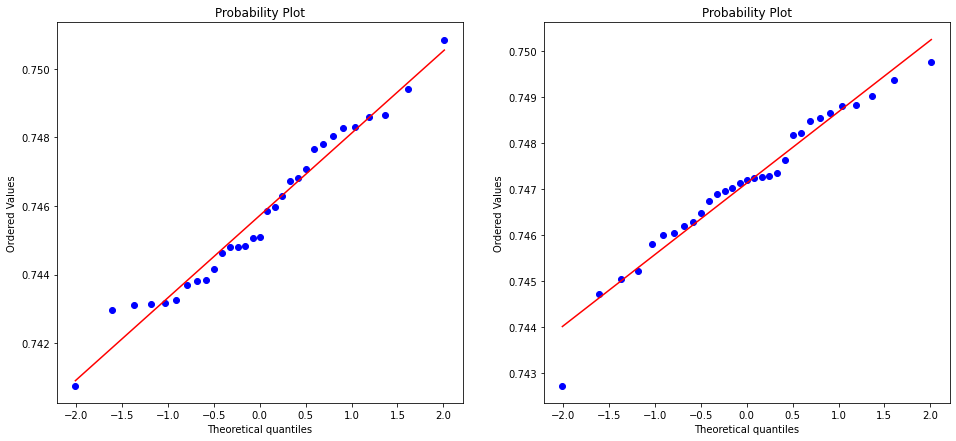

Тест Шапиро-Уилка для модели без гиперпараметров p-value=0.5859202146530151
Тест Шапиро-Уилка для модели с гиперпараметрами p-value=0.3811429738998413



In [31]:
#оценим интервально средние с помощью t-критерия, проверим распределения на нормальность формально и визуально
#поскольку t-критерий допускает незначительные отклонения от нормальности
plt.figure(figsize=(16,7))
plt.subplot(121)
sc.stats.probplot(np.array(ctb_outofbox_results), dist="norm", plot=plt)
plt.subplot(122)
sc.stats.probplot(np.array(ctb_model_results), dist="norm", plot=plt)
plt.show()
print('Тест Шапиро-Уилка для модели без гиперпараметров p-value={}\n'
     'Тест Шапиро-Уилка для модели с гиперпараметрами p-value={}\n'.format(stats.shapiro(np.array(ctb_outofbox_results))[1],
                                                                          stats.shapiro(np.array(ctb_model_results))[1]))

Как видно и визуально и с помощью Теста Шапиро-Уилка можно заключить, что результаты работы обоих моделей имеют нормальное распределение, можно использовать t-тест

In [32]:
#сформируем выборочные статистики для удобства
model_outofbox_mean = np.array(ctb_outofbox_results).mean()
model_outofbox_std = np.array(ctb_outofbox_results).std(ddof=1)
model_hyper_mean = np.array(ctb_model_results).mean()
model_hyper_std = np.array(ctb_model_results).std(ddof=1)

In [34]:
print("95% доверительный интервал для модели без гиперпараметров", _tconfint_generic(model_outofbox_mean,
                                                                                     model_outofbox_std,
                                                                                     len(ctb_outofbox_results) - 1,
                                                                                     0.05, 'two-sided'))

print("95% доверительный интервал для модели с гиперпараметрами", _tconfint_generic(model_hyper_mean,
                                                                                    model_hyper_std,
                                                                                    len(ctb_model_results) - 1,
                                                                                    0.05, 'two-sided'))

95% доверительный интервал для модели без гиперпараметров (0.7409465382679689, 0.7505066697931521)
95% доверительный интервал для модели с гиперпараметрами (0.7440104242991484, 0.7502358969995132)


Интервалы сильно пересекаются, сказать что одна модель в среднем лучше другой нельзя. Воспользуемся t-тестом Стьюдента для связных выборок. Будем проверять нулевую гипотезу о том, что средние моделей равны против двусторонней альтернативы о том, что они не равны.

Для начала проверим, что попарные разности двух моделей не сильно отличаются от нормального распределения.

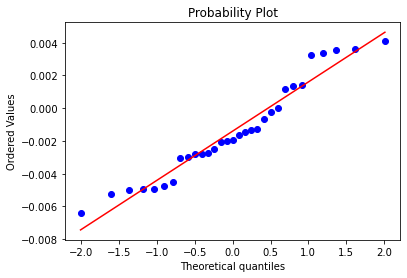

In [36]:
stats.probplot(np.array(ctb_outofbox_results) - np.array(ctb_model_results), dist = "norm", plot = plt)
plt.show()

In [38]:
print("Тест Шапиро-Уилка для разности моделей: %f, p-value: %f" % stats.shapiro(np.array(ctb_outofbox_results) - np.array(ctb_model_results)))

Тест Шапиро-Уилка для разности моделей: 0.942955, p-value: 0.099622


На уровне значимости 0,05 гипотеза о нормальности распределения не отвергается, тест Шапиро-Уилка и визуальный анализ позволяют судить о нормальности распределения разности результатов моделей. Проверим гипотезу о равенстве средних двух распределений.

In [39]:
stats.ttest_rel(np.array(ctb_outofbox_results), np.array(ctb_model_results))

Ttest_relResult(statistic=-2.631000864109118, pvalue=0.013310955047453315)

In [52]:
#оценим доверительный интервал разности
from statsmodels.stats.weightstats import *
print("95%% доверительный интервал: [%f, %f]" % DescrStatsW(np.array(ctb_model_results) - np.array(ctb_outofbox_results)).tconfint_mean())

95% доверительный интервал: [0.000313, 0.002481]


T-тест Стьюдента не позволяет отвергнуть нулевую гипотезу о равенстве средних на уровне значимости 0,05. Однако доверительный интервал для разности долей полностью располагается правее нуля, что говорит о том, что в среднем результаты модели с гиперпараметрами всегда лучше модели без гиперпараметров.

Попробуем построить оценки для доверительных интервалов долей и, если будет не достаточно, разности долей для связных выборок.
Для начала сформируем выборку данных

In [96]:
data = np.vstack((np.array(ctb_outofbox_results), np.array(ctb_model_results)))

In [97]:
data = pd.DataFrame(data).T
data = data.rename(columns={0:'out_of_box_res', 1:'with_hyper_res'})
data['out_of_box_win'] = np.where(data['out_of_box_res']>data['with_hyper_res'], 1, 0)
data['with_hyper_win'] = np.where(data['with_hyper_res']>data['out_of_box_res'], 1, 0)

In [99]:
data.head(5)

,out_of_box_res,with_hyper_res,out_of_box_win,with_hyper_win
0,0.748294,0.745030,1,0
1,0.743822,0.745796,0,1
2,0.749402,0.746039,1,0
3,0.748036,0.746874,1,0
4,0.743844,0.748787,0,1


In [100]:
#интервальные оценки
data[['out_of_box_win', 'with_hyper_win']].describe()

,out_of_box_win,with_hyper_win
count,31.000000,31.000000
mean,0.290323,0.709677
std,0.461414,0.461414
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [108]:
from statsmodels.stats.proportion import proportion_confint
model_out_of_box = proportion_confint(sum(data['out_of_box_win']), 
                                      np.array(ctb_outofbox_results).shape[0],
                                      method = 'wilson')
model_hyper = proportion_confint(sum(data['with_hyper_win']),
                                 np.array(ctb_outofbox_results).shape[0],
                                 method = 'wilson')

In [109]:
print('Доверит. интервал модели без гиперпараметров [%f, %f]' % model_out_of_box)
print('Доверит. интервал модели с гиперпараметрами [%f, %f]' % model_hyper)

Доверит. интервал модели без гиперпараметров [0.160958, 0.465923]
Доверит. интервал модели с гиперпараметрами [0.534077, 0.839042]


Доверительный интервал для доли для модели с гиперпараметрами полностью правее модели без гиперпараметров, то есть имеются статистически значимые различия в результатах алгоритмов. Интервальную оценку для разности долей можно не производить. 

Таким образом результаты следующие:
* Распределение результатов работы алгоритмов на отложенной выборке нормальное
* Доверительные интервалы пересекаются, выводов в отличии моделей сделать нельзя
* Т-тест Стьюдента для зависимых выборок не отвергает нулевую гипотезу о равенстве средних
* Доверительный интервал разности средних не содержит нуля, что говорит о существовании статистически значимых различий в средних алгоритмов
* Доверительный интервал для долей модели с подбором гиперпараметров полностью правее интервала для модели без гиперпараметров, что говорит о статистически значимых различиях

До этого мы пользовались только параметрическими критериями, воспользуемся так же одним непараметрическим перестановочным критерием. Будем проверять нулевую гипотезу о том, что разница матожидания скоров моделей равна нулю (то есть матожидания равны) против двусторонней альтернативы о том, что они не равны. В Python реализации нет, необходимы дополнительный функции 

In [110]:
#расчет Т-статистики
def permutation_t_stat_1sample(sample, mean):
    t_stat = sum(list(map(lambda x: x - mean, sample)))
    return t_stat

In [111]:
#расчет нулевого распределения Т-статистики
def permutation_zero_distr_1sample(sample, mean, max_permutations = None):
    centered_sample = list(map(lambda x: x - mean, sample))
    if max_permutations:
        signs_array = set([tuple(x) for x in 2 * np.random.randint(2, size = (max_permutations, 
                                                                              len(sample))) - 1 ])
    else:
        signs_array =  itertools.product([-1, 1], repeat = len(sample))
    distr = [sum(centered_sample * np.array(signs)) for signs in signs_array]
    return distr

In [116]:
#реализация перестановочного критерия
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_1sample(sample, mean)
    
    zero_distr = permutation_zero_distr_1sample(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [131]:
print("p-value two-sided: %f" % permutation_test(data['with_hyper_res'] - data['out_of_box_res'], 0., max_permutations = 80000))

p-value two-sided: 0.013113


In [133]:
print("p-value greater: %f" % permutation_test(data['with_hyper_res'] - data['out_of_box_res'], 0., max_permutations = 80000,
                                              alternative = 'greater'))

p-value greater: 0.007313


Двусторонняя альтернатива не позволяет отвергнуть нулевую гипотезу о равенстве средних, однако односторонняя альтернатива о том, что в среднем результат модели с гиперпараметрами не лучше модели без подбора гиперпараметров отвергается на уровне значимости 0,05.

С учетом проделанных статистических тестов предлагается использовать модель с подбором гиперпараметров, как дающую лучший результат.

## Оценка модели с точки зрения экономического эффекта

Построим кривые прироста концентрации и количества метки целевого класса в зависимости от взятого объёма выборки.

In [138]:
import scikitplot as skplt
#возвращенные вероятности меток классификатором
y_probas = ctb_model.predict_proba(X_test_cat)

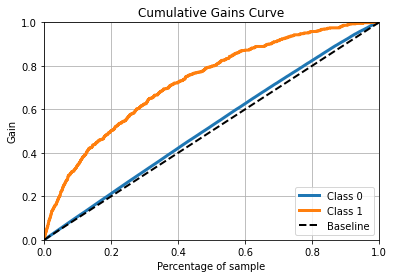

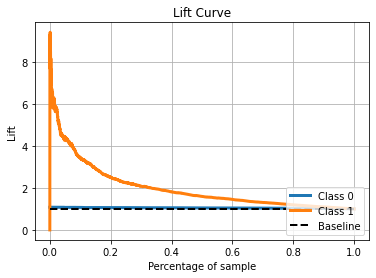

In [139]:
#отрисовка кривых
skplt.metrics.plot_cumulative_gain(y_test, y_probas)
plt.show()

skplt.metrics.plot_lift_curve(y_test, y_probas)
plt.show()

На графике "Cumulative Gains Curve" по оси "x" отражается объем выборки в %, по оси "y" количество меток целевого класса при данном объеме выборки.
На графике "Lift Curve" по оси "x" отражается объем выборки в %, по оси "y" на то, во сколько раз при данном объеме выборки меток целевого класса больше согласно ранжированию классификатора, чем при случайно отборе такого же объёма выборки.

На основе разработанного алгоритма ранжирования клиентов определим, будет ли кампания по удержанию, основанная на работе данного алгоритма, эффективна. Зададим следующие граничные условия:
* себестоимость телеком-оператора 65 % выручки от абонента (https://bcs-express.ru/novosti-i-analitika/komu-iz-operatorov-sotovoi-sviazi-klienty-platiat-bol-she-vsego)
* средний доход с одного клиента возьмем как среднее по большой тройке операторов (https://www.vedomosti.ru/technology/articles/2019/06/09/803807-tele2-oboshla-megafon) - arpu
* средневзвешенное нахождение человека у одного оператора 5 лет
* кампания по удержанию заключается в предоставлении скидки на услуги сотовой связи на 1 год в размере 20%, плюс стоимость доставки до человека нашего предложения посредством смс и др 1 р/клиент. 
* 70% людей, получивших смс, примут предложение остаться у данного оператора



In [140]:
#всего лояльных клиентов в выборке
total_overall = np.unique(y_train, return_counts=True)[1][0]
#всего клиентов, склонных к оттоку
total_churn = np.unique(y_train, return_counts=True)[1][1]

In [141]:
#средний доход с одного клиента 
arpu = (333 + 323 + 293) / 3
#среднее время нахождения человекау одного оператора примем 5 лет
lt = 5 * 12
#1 - себестоимость
self_cost = 0.35
#lifetime value от клиента в среднем
ltv = arpu * lt * self_cost
#вероятность приниятия предложения
prob_return = 0.7

In [142]:
#порог в первом приближении
thresh_churn = 0.8
thresh_overall = 0.5
#среднее количество реально уходящих клиентов от уровня порога
churn_rate = total_churn * thresh_churn
#количество неверно определенных к оттоку клиентов при этом же ранжировании
overall_rate = total_overall * thresh_overall
#скидка за связь
discount = 0.2
#стоимость удержания одного клиента
total_cost = arpu * discount * 12 + 1

In [144]:
#посмотрим на выручку в зависимости от порога
actual = np.ravel(y_test.values)
predicted = ctb_model.predict_proba(X_test_cat)[:, 1]
data = zip(actual, predicted)
sorted_data = sorted(data, key=lambda d: d[1], reverse=True)
sorted_actual = [d[0] for d in sorted_data]
cumulative_actual = np.cumsum(sorted_actual) / sum(actual)
cumulative_index = np.arange(1, len(cumulative_actual)+1) / len(predicted)

In [145]:
#функция возвращающая лучшее значение выручки и пороги при нём
def calc_max(t_churn, t_overall):
    max_profit = 0
    params = []
    
    for i in range(len(t_churn)):
        profit = (ltv * (total_churn * t_churn[i] * prob_return)) - (total_cost * (total_overall * t_overall[i]))
         
        if profit >= max_profit:
            params.clear()
            max_profit = profit
            params = [t_churn[i], t_overall[i]]
    return [max_profit, params]

In [146]:
results = calc_max(cumulative_actual, cumulative_index)


In [147]:
print('Если при проведении кампании по удержанию алгоритм применяется на 8 тысяч человек, наибольший эффект\n'
     'будет достигнут при выборе первых {} % выборки после ранжирования в которых будет {} человека склонных к оттоку\n'
     'из {} человек склонных к оттоку в исходной выборке и экономический эффект от данной кампании составит {} рублей'.format(((round(results[1][1] * 100, 3))),
     int(round((total_churn * results[1][0]), 1)), total_churn, int(round(results[0], 1))))

Если при проведении кампании по удержанию алгоритм применяется на 8 тысяч человек, наибольший эффект
будет достигнут при выборе первых 13.312 % выборки после ранжирования в которых будет 1000 человека склонных к оттоку
из 2381 человек склонных к оттоку в исходной выборке и экономический эффект от данной кампании составит 1654562 рублей


In [148]:
#построим график зависимости порога выборки от полученных денег
profit = []
churn_portion = []
overall_portion = []
for i in range(len(cumulative_actual)):
    money = (ltv * (total_churn * cumulative_actual[i] * prob_return)) - (total_cost * (total_overall * cumulative_index[i]))
    profit.append(money)
    churn_portion.append(cumulative_actual[i])
    overall_portion.append(cumulative_index[i])
    

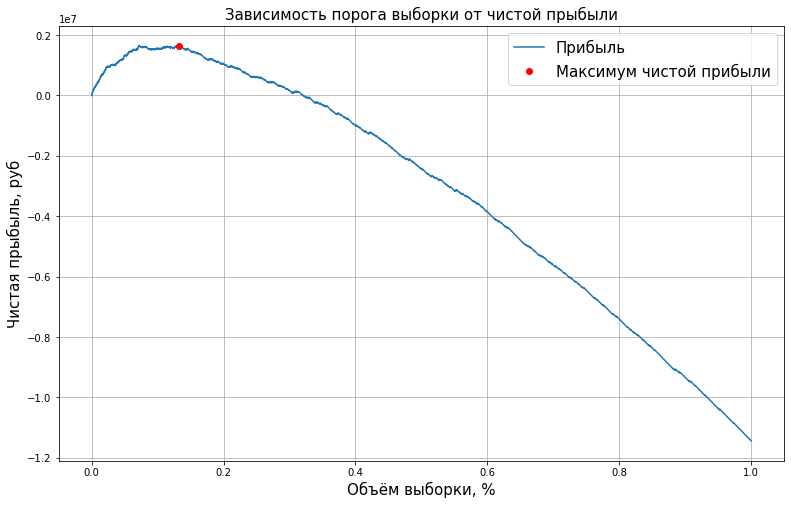

In [149]:
#отрисовка графика
fig, ax = plt.subplots(figsize=(13, 8))
ax.plot(overall_portion, profit, label='Прибыль')
ax.set_xlabel('Объём выборки, %', fontsize=15)
ax.set_ylabel('Чистая прыбыль, руб', fontsize=15)
ax.plot(results[1][1], results[0], 'o', color='r', label='Максимум чистой прибыли')
ax.grid()
ax.legend(fontsize=15)
plt.title('Зависимость порога выборки от чистой прыбыли', fontsize=15)
plt.show()

2. Как видно из графика, чистая прибыль растет до примерно 13% выборки и затем начинает падать. 
3. Экономическая модель была усложнена, она учитывает прибыль с клиента, себестоимость услуг, вероятность принятия предложения клиентом.
4. Как видно из графика, применение модели не всегда экономически целесообразно. Порог надо подбирать качествено с учетом максимизации прибыли.
5. Оценить как качество модели повлияет на чистую прибыль в денежном выражении не представляется возможным, поскольку мы используем ранжирование как критерий выбора топа, смоделировать ранжирование по целевой метрике в зависимости увеличения точности модели для оценки денег не выйдет. Очевидно одно, что при увеличении точности ранжирование в топе должно увеличиваться и модель должна показывать еще больший прирост концентрации метки целевого класса в топе
6. Вложение средств в данную модель экономически целесообразно при верном выборе порога, в таком случае можно получить чистую прибыль.
7. Данный алгоритм при использовании колл-центра можно использовать по иному, применяя его на k человек, где k - количество операторов, задействованных в удержании клиентов. В данном случае предпочтительной метрикой для оценки качества будет являться precision@k, однако это медленнее и дороже, чем предложенный подход.

Предложение по тестированию алгоритма на реальных пользователях.

1. Необходимо выбрать некоторый % пользователей (допустим 2%) и поделить их на две группы.
2. В одной группе при удержании использовать алгоритм случайного сэмлирования, то есть генератором случайных чисел выбирать тех людей, которые планируют уйти. В другой группе использовать предложенный алгоритм.
3. Далее сравнить качество по метрике. В качестве метрики можно использовать "среднее количество пользователей, склонных к оттоку в выборке". Данный критерий можно проверить с помощью метода доверительных интервалов для доли, проряя нулевую гипотезу о том, что количество людей при применении алгоритма не изменилось, против односторонней или двусторонней альтернативы, сформировав выборку формата [1, 1, 0, 0, 1...]. Так же следует на постоянной основе производить А/А тесты, что позволит сделать А/Б тесты более устойчивыми.
4. При накоплении статистики по среднему количеству пользователей склонных к оттоку, возможно использовать другие критерии проверки, например метод бутсрапа, тест манна-уитни, перестановочный критерий.
5. Рекомендуется производить переобучение алгоритма при поступлении новых данных, поскольку пользовательское поведение обычно достаточно сильно подвержено изменениям.

## Возможности улучшения алгоритма

In [154]:
#подготовим данные для катбуста, возьмем всю выборку
df = pd.concat((X_train_cat, X_test_cat))
y = pd.concat((y_train, y_test))

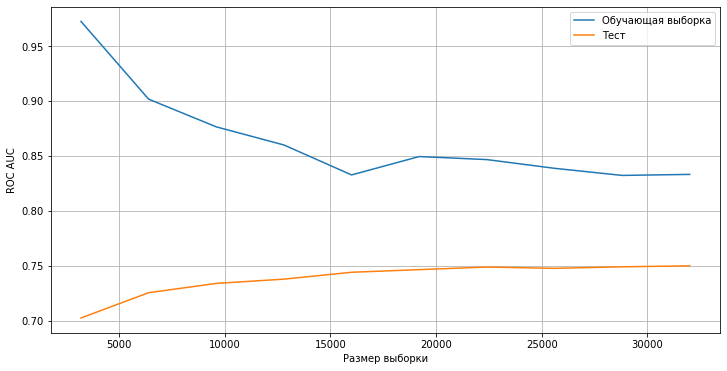

In [155]:
#посмотрим как объём выборки влияет на качество, возможно необходимо увеличить количество данных для обучения
train_sizes, train_scores, test_scores = learning_curve(ctb_model, df, y, cv=StratifiedKFold(), scoring='roc_auc',
                                                       train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.figure(figsize=(12,6))
plt.plot(train_sizes, train_scores.mean(axis=1), label=u"Обучающая выборка")
plt.plot(train_sizes, test_scores.mean(axis=1), label=u"Тест")
plt.xlabel(u'Размер выборки')
plt.ylabel(u'ROC AUC')
plt.legend(loc="best")
plt.grid()
plt.show()

Увеличение объёма данных не поможет существенно улучшить качество модели, качество на тесте выходит на асимптоту. 
Прирост качества модели можно добиться за счет следующих действий:
1. Деанонимизации фичей, что позволит выполнить более детальный анализ и визуализацию данных, сделать более сильные признаки и удалить шумовые.
2. Сделать выборку данных более "числой". В данных слишком много пропусков, необходимо понять их природу и обрабатывать определенным образом.
3. Попробовать использовать другие модели, например нейронные сети.

